В этом ноутбуке мы разберемся с тем, как работают методы снижения размерности и кластеризации данных.Мы будем работать с набором данных Samsung Human Activity Recognition. 

Работа частично основана на материалах домашнего задания 7, курса ODS.

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
!unzip -q UCI\ HAR\ Dataset.zip
!mv -v UCI\ HAR\ Dataset data

--2022-12-06 09:52:10--  https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60999314 (58M) [application/x-httpd-php]
Saving to: ‘UCI HAR Dataset.zip’

UCI HAR Dataset.zip 100%[===================>]  58.17M  16.6MB/s    in 3.5s    

2022-12-06 09:52:14 (16.6 MB/s) - ‘UCI HAR Dataset.zip’ saved [60999314/60999314]



In [ ]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import notebook

%matplotlib inline
from matplotlib import pyplot as plt

plt.style.use(["seaborn-darkgrid"])
plt.rcParams["figure.figsize"] = (12, 9)
plt.rcParams["font.family"] = "DejaVu Sans"

from sklearn import metrics
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import adjusted_rand_score

from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

In [ ]:
PATH_TO_SAMSUNG_DATA = "data/"

In [ ]:
X_train = np.loadtxt(os.path.join(PATH_TO_SAMSUNG_DATA, "train/X_train.txt"))
y_train = np.loadtxt(
    os.path.join(PATH_TO_SAMSUNG_DATA, "train/y_train.txt")
).astype(int)

X_test = np.loadtxt(os.path.join(PATH_TO_SAMSUNG_DATA, "test/X_test.txt"))
y_test = np.loadtxt(
    os.path.join(PATH_TO_SAMSUNG_DATA, "test/y_test.txt")
).astype(int)

In [ ]:
# Checking dimensions
assert X_train.shape == (7352, 561) and y_train.shape == (7352,)
assert X_test.shape == (2947, 561) and y_test.shape == (2947,)

For clustering, we do not need a target vector, so we'll work with the combination of training and test samples. Merge `X_train` with `X_test`, and `y_train` with `y_test`.

In [ ]:
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

Define the number of unique values of the labels of the target class.

In [ ]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [ ]:
n_classes = np.unique(y).size

[Метки классов:](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)
- 1 – walking
- 2 – walking upstairs
- 3 – walking downstairs
- 4 – sitting
- 5 – standing
- 6 – laying down

Стандартизируем признаки

In [ ]:
# Your code here
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Сократим размерность данных с помощью PCA, оставив столько компонент, сколько необходимо для объяснения не менее 90% дисперсии исходных (масштабированных) данных.

In [ ]:
pca = PCA(random_state=RANDOM_STATE).fit(X_scaled)
for i, v in enumerate(np.cumsum(pca.explained_variance_ratio_)):
    if v > 0.9:
        print(i + 1, v)
        break

65 0.9004833346822928


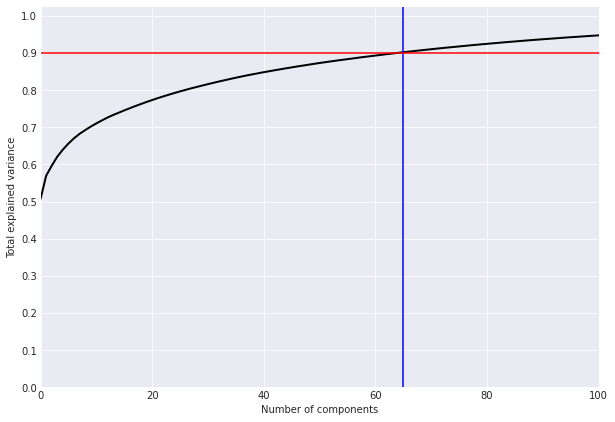

In [ ]:
pca = PCA().fit(X_scaled)

plt.figure(figsize=(10,7))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='black', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 100)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(65, c='b')
plt.axhline(0.9, c='r')
plt.show();

Визуализация данных в проекции на первые две компоненты.

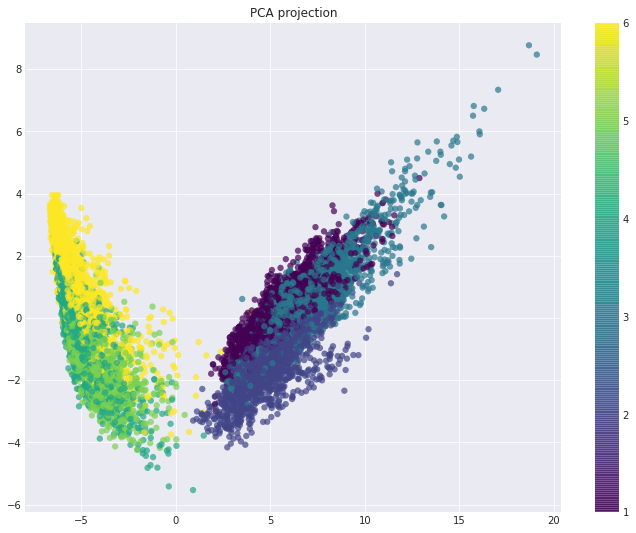

In [ ]:
pca = PCA(n_components=65, random_state=RANDOM_STATE)
X_reduced = pca.fit_transform(X)

plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, 
            edgecolor='none', alpha=0.7, s=40,
            cmap="viridis")
plt.colorbar()
plt.title('PCA projection');

Сравним с TSNE

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Text(0.5, 1.0, 't-SNE projection')

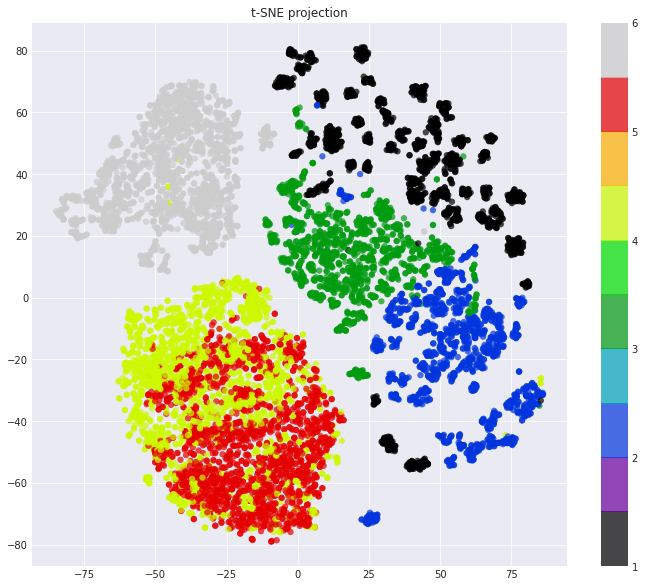

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(random_state=RANDOM_STATE)

X_tsne = tsne.fit_transform(X_reduced)

plt.figure(figsize=(12,10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('t-SNE projection')

Выводы.  
PCA: разделил данные на два четких кластера -
(walking, walking upstairs, walking downstairs ) и (sitting, standing, laying)

TSNE: судя по всему, уловил более сложные нелинейные закономерности. И смог отделить 6 класс от 5 и 4, а так же 1,2 и 3 классы разведены сильнее, чем у PCA. Хотя их все равно можно выделить в один кластер.

------------------------------

Выполним кластеризацию методом KMeans, обучая модель на данных с уменьшенной размерностью (по PCA).

Параметры:

- ** n_clusters ** = n_classes (количество классов)
- ** n_init ** = 100
- ** random_state ** = RANDOM_STATE

In [ ]:
kmeans = KMeans(n_clusters=n_classes, n_init=100, random_state=RANDOM_STATE).fit(X_reduced)

Визуализируем в двумерной проекции

In [ ]:
cluster_labels = kmeans.predict(X_reduced)

Text(0.5, 1.0, 'PCA projection + kmeans')

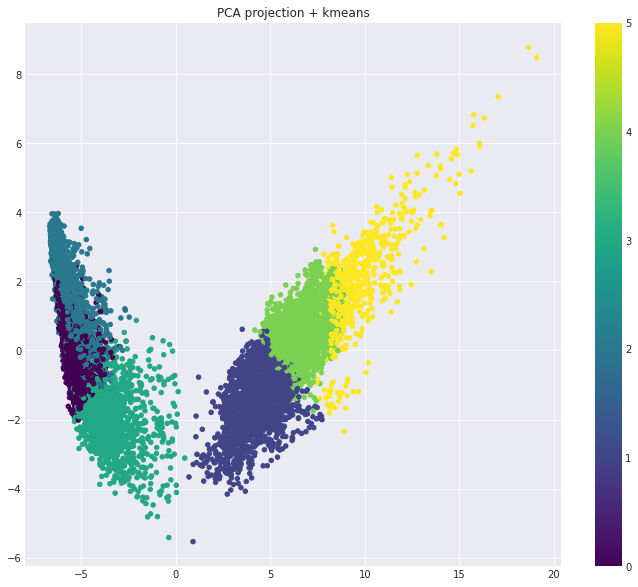

In [ ]:
plt.figure(figsize=(12,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=cluster_labels, s=20, cmap='viridis')
plt.colorbar()
plt.title('PCA projection + kmeans')

Посмотрим на соответствие между метками кластера и метками исходного класса, определим на каких классах алгоритм KMeans ошибается.

In [ ]:
tab_kmeans = pd.crosstab(y, cluster_labels, margins=True)
tab_kmeans.index = ['walking', 'going up the stairs',
            'going down the stairs', 'sitting', 'standing', 'laying', 'all']
tab_kmeans.columns = ['cluster' + str(i + 1) for i in range(6)] + ['all']
tab_kmeans

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,all
walking,0,703,0,0,866,153,1722
going up the stairs,0,1168,0,0,294,82,1544
going down the stairs,0,187,0,0,764,455,1406
sitting,1258,3,49,467,0,0,1777
standing,1240,0,0,666,0,0,1906
laying,0,12,1760,172,0,0,1944
all,2498,2073,1809,1305,1924,690,10299


Мы видим, что для каждого класса (т. е. каждой деятельности) есть несколько кластеров. Давайте посмотрим на максимальный процент объектов в классе, которые относятся к одному кластеру. Это будет простая метрика, характеризующая, насколько легко класс отделяется от других при кластеризации.

In [ ]:
pd.Series(
    tab_kmeans.iloc[:-1, :-1].max(axis=1).values / tab_kmeans.iloc[:-1, -1].values,
    index=tab_kmeans.index[:-1],
)

walking                  0.502904
going up the stairs      0.756477
going down the stairs    0.543385
sitting                  0.707935
standing                 0.650577
laying                   0.905350
dtype: float64

Видно, что kMeans не очень хорошо различает действия. Используем метод локтя и метод силуэта, чтобы выбрать оптимальное количество кластеров. Параметры алгоритма и данные, которые мы используем, такие же, как и раньше, мы меняем только n_clusters.

In [ ]:
inertia = []
silhouette = [0]
for k in notebook.tqdm(range(1, n_classes + 1)):
    kmeans = KMeans(n_clusters=k, n_init=100, random_state=RANDOM_STATE).fit(X_reduced)
    inertia.append(np.sqrt(kmeans.inertia_))
    if k >= 2:
        silhouette.append(silhouette_score(X_reduced, kmeans.labels_))


  0%|          | 0/6 [00:00<?, ?it/s]

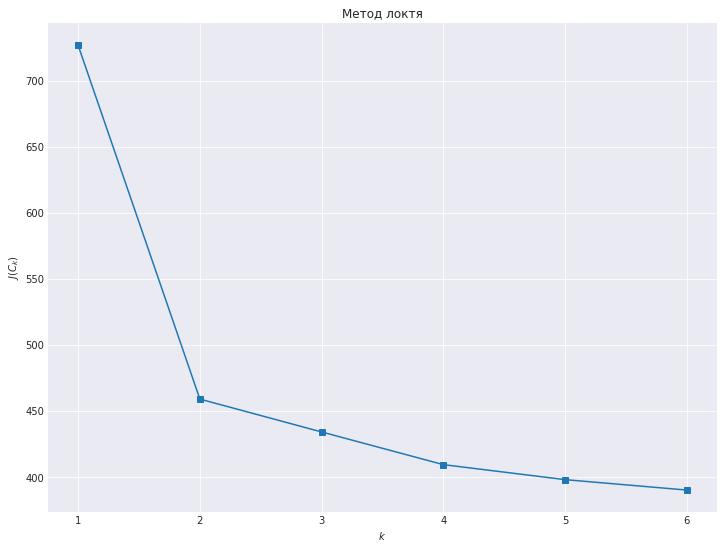

In [ ]:
plt.plot(range(1, n_classes + 1), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$')
plt.title('Метод локтя');

Text(0.5, 1.0, 'Метод силуэта')

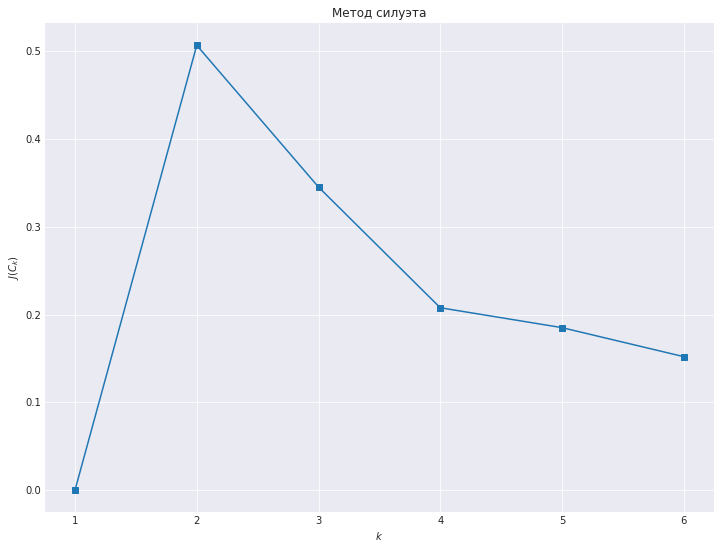

In [ ]:
plt.plot(range(1, n_classes + 1), silhouette, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');
plt.title('Метод силуэта')

Вывод: нужно использовать два кластера для лучшей кластеризации

------------------------

Попробуем другой алгоритм кластеризации — агломеративную кластеризацию.

In [ ]:
ag = AgglomerativeClustering(linkage='ward').fit(X_reduced)
ag_labels = ag.labels_

Text(0.5, 1.0, 'PCA projection + agglomerative clustering')

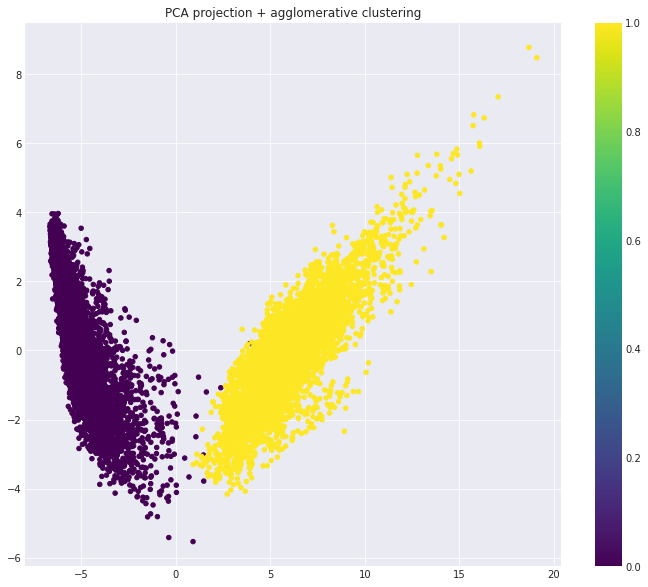

In [ ]:
plt.figure(figsize=(12,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=ag_labels, s=20, cmap='viridis')
plt.colorbar()
plt.title('PCA projection + agglomerative clustering')

Посмотрим на дендограмму

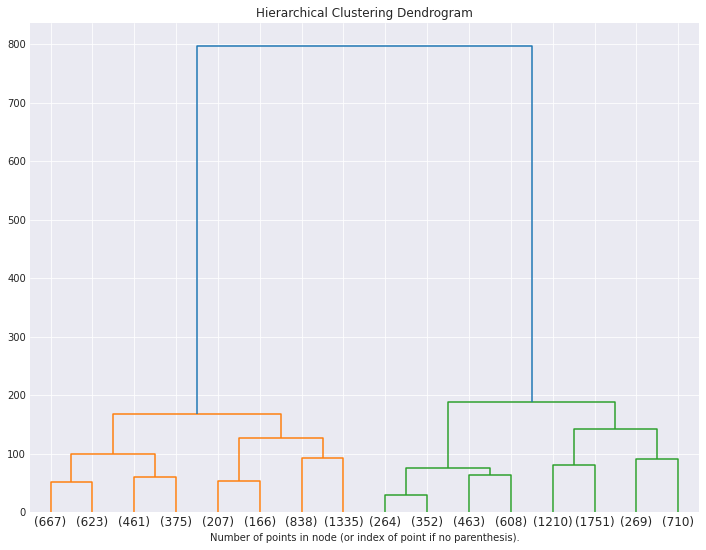

In [ ]:
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

model = AgglomerativeClustering(linkage='ward', compute_distances=True).fit(X_reduced)

ag_labels = ag.labels_
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()


Рассчитаем скорректированный индекс Рэнда (adjusted_rand_score) для полученной агломеративной кластеризации и для KMeans с двумя кластерами.

In [ ]:
# Your code here
# Your code here
kmeans = KMeans(n_clusters=2, n_init=100, random_state=RANDOM_STATE).fit(X_reduced)
kmeans_labels = kmeans.predict(X_reduced)

Text(0.5, 1.0, 'PCA projection + kmeans 2 clusters')

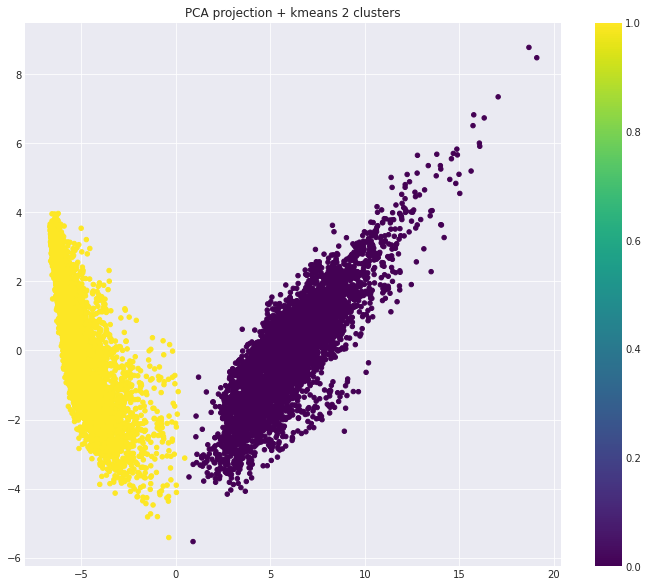

In [ ]:
plt.figure(figsize=(12,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=kmeans_labels, s=20, cmap='viridis')
plt.colorbar()
plt.title('PCA projection + kmeans 2 clusters')

In [ ]:
print("KMeans 2 clusters: ARI =", adjusted_rand_score(kmeans_labels, y))
print("Agglomerative CLustering 2 clusters: ARI =", adjusted_rand_score(ag_labels, y))

KMeans 2 clusters: ARI = 0.3306882968763086
Agglomerative CLustering 2 clusters: ARI = 0.33253220715485143


Рассчитаем ту же метрику для 6 кластеров

In [ ]:
ag_6 = AgglomerativeClustering(n_clusters=n_classes, linkage="ward").fit(X_reduced)

In [ ]:
print("KMeans 6 clusters: ARI =", adjusted_rand_score(cluster_labels, y))
print("Agglomerative CLustering 6 clusters: ARI =", adjusted_rand_score(ag_6.labels_, y))

KMeans 6 clusters: ARI = 0.4612655802913403
Agglomerative CLustering 6 clusters: ARI = 0.5150910537864881


По метрике ARI, KMeans справился с разделением на кластеры хуже, чем агломеративная кластеризация.

-------------------------------

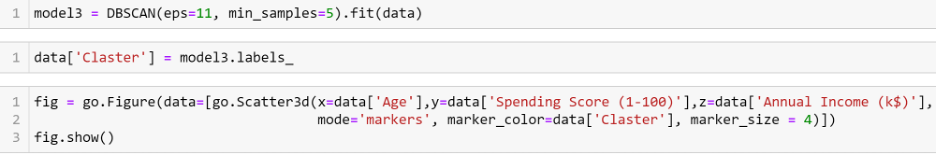

In [ ]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=5, min_samples=10).fit(X_reduced)

In [ ]:
dbscan.labels_

array([0, 0, 0, ..., 0, 0, 0])

Text(0.5, 1.0, 'PCA projection + dbscan')

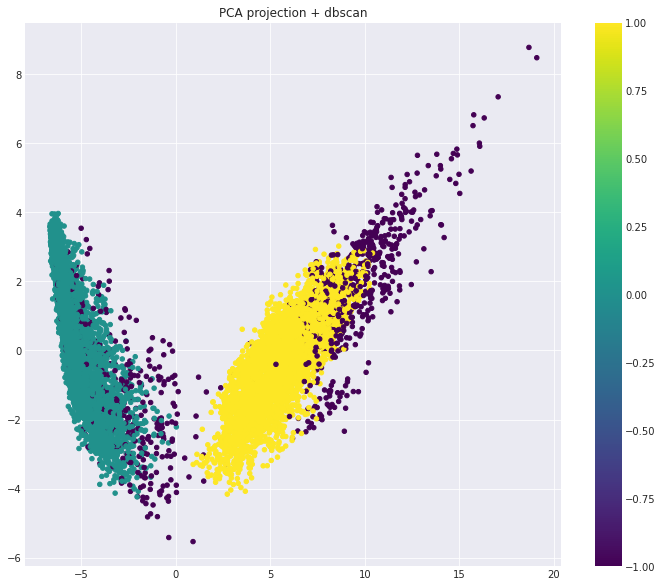

In [ ]:
dbscan = DBSCAN(eps=4, min_samples=50, p=2).fit(X_reduced)
plt.figure(figsize=(12,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=dbscan.labels_, s=20, cmap='viridis')
plt.colorbar()
plt.title('PCA projection + dbscan')

In [ ]:
print("dbscan: ARI =", adjusted_rand_score(dbscan.labels_, y))

dbscan: ARI = 0.31720459903091897


Можно заметить, что задача не очень хорошо решается, когда мы пытаемся обнаружить несколько кластеров (> 2). Теперь давайте решим задачу классификации, учитывая, что данные помечены.

Используем LinearSVC из sklearn

Подберем гиперпараметр `C` для ` LinearSVC` используя `GridSearchCV`.

In [ ]:
# # Your code here
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
svc = LinearSVC(max_iter=3000, random_state=RANDOM_STATE)
svc_params = {"C": [0.001, 0.01, 0.1, 1, 10]}

In [ ]:
%%time
# # Your code here
clf = GridSearchCV(svc, svc_params, cv=3)
clf.fit(X_train_scaled, y_train)
best_svc = clf.best_estimator_

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warning

CPU times: user 1min 41s, sys: 1.59 s, total: 1min 43s
Wall time: 1min 47s


In [ ]:
clf.best_params_, clf.best_score_

({'C': 0.1}, 0.9382506099134881)

In [ ]:
y_predicted = best_svc.predict(X_test_scaled)

In [ ]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['walking', 'climbing up the stairs',
             'going down the stairs', 'sitting', 'standing', 'laying', 'all']
tab.columns = ['walking', 'climbing up the stairs',
             'going down the stairs', 'sitting', 'standing', 'laying', 'all']
tab

,walking,climbing up the stairs,going down the stairs,sitting,standing,laying,all
walking,494,2,0,0,0,0,496
climbing up the stairs,12,459,0,0,0,0,471
going down the stairs,2,4,413,1,0,0,420
sitting,0,4,0,426,61,0,491
standing,0,0,0,15,517,0,532
laying,0,0,0,0,11,526,537
all,508,469,413,442,589,526,2947


In [ ]:
print(metrics.classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           1       0.97      1.00      0.98       496
           2       0.98      0.97      0.98       471
           3       1.00      0.98      0.99       420
           4       0.96      0.87      0.91       491
           5       0.88      0.97      0.92       532
           6       1.00      0.98      0.99       537

    accuracy                           0.96      2947
   macro avg       0.97      0.96      0.96      2947
weighted avg       0.96      0.96      0.96      2947



Сделаем тоже самое, но с использованием PCA.

In [ ]:
# Your code here
X_train_scaled_pca = pca.fit_transform(X_train_scaled)
X_test_scaled_pca = pca.transform(X_test_scaled)

In [ ]:
%%time
# # Your code here
clf = GridSearchCV(svc, svc_params, cv=3)
clf.fit(X_train_scaled_pca, y_train)
best_svc = clf.best_estimator_

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warning

CPU times: user 26.9 s, sys: 1.62 s, total: 28.5 s
Wall time: 26.6 s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [ ]:
clf.best_params_, clf.best_score_

({'C': 0.1}, 0.8979898250609913)

Выводы:

1. PCA сильно сокращает время обучения, но качество предсказания упало на 4%
2. PCA можно использовать для визуализации данных, но для этой задачи есть методы получше, например, tSNE. Однако PCA имеет меньшую вычислительную сложность.
3. PCA строит линейные комбинации исходных функций, и иногда они могут плохо интерпретироваться людьми.